<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/transformer_generator/Transformer_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from pathlib import Path
import functools 
import pdb

Path.ls = lambda x: list(x.iterdir())

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

In [ ]:
!git clone -b transformer_generator https://github.com/azfarkhoja305/GANs.git

In [4]:
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [5]:
from utils.utils import check_gpu
from utils.trunc_normal import trunc_normal_
from utils.layers import DropPath, gelu, LinearReshape, Block, PixelUpsample, To_RGB

## Attention Mask

In [6]:
# TODO: Is this the one in the paper? 
# Doesn't seem so
def get_attn_mask(N, w):
    mask = torch.zeros(1, 1, N, N)
    for i in range(N):
        if i <= w:
            mask[:, :, i, 0:i+w+1] = 1
        elif N - i <= w:
            mask[:, :, i, i-w:N] = 1
        else:
            mask[:, :, i, i:i+w+1] = 1
            mask[:, :, i, i-w:i] = 1
    return mask

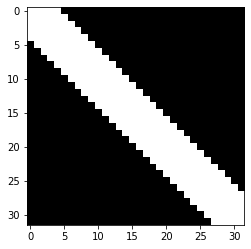

In [7]:
mask = get_attn_mask(32,4)
plt.imshow(mask.squeeze(), cmap='gray')

## Drop Path

In [27]:
#(Batch_sz, num_token, embedding)
samples = torch.ones(2,4,8)
samples

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]])

In [32]:
# Zeros out an entire input sample +
# scales up remaining samples
drop_path = DropPath(drop_prob=0.5)
drop_path(samples)

tensor([[[2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])

## Transformer Generator

In [8]:
class TGenerator(nn.Module):
    def __init__(self, latent_dims=1024, img_size=32, bottom_width=8, embed_chs=384, depth=[5,2,2],
                 drop_path_rate=0, num_heads=4, mlp_ratio=4, qkv_bias=False, qk_scale=None,  
                 mlp_drop=0, attn_drop=0, att_mask=False, act_layer=gelu, norm_layer=nn.LayerNorm):
        super().__init__()
        assert isinstance(depth, list) and len(depth) == 3

        self.in_layer = LinearReshape(in_dims=latent_dims, out_dims=embed_chs*bottom_width**2, 
                                      width=bottom_width, embed_chs=embed_chs)
        self.pos_embed = [
                          nn.Parameter(torch.zeros(1, bottom_width**2, embed_chs)),
                          nn.Parameter(torch.zeros(1, (bottom_width*2)**2, embed_chs//4)),
                          nn.Parameter(torch.zeros(1, (bottom_width*4)**2, embed_chs//16))
        ]
        for emb in self.pos_embed:
            trunc_normal_(emb, std=.02)

        Partial_Block = functools.partial(Block, num_heads=num_heads, mlp_ratio=mlp_ratio, 
                            qkv_bias=qkv_bias, qk_scale=qk_scale, mlp_drop=mlp_drop, attn_drop=attn_drop, 
                            att_mask=att_mask, act_layer=act_layer, norm_layer=norm_layer)
        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth[0])]  
        self.bottom_block = nn.ModuleList([ 
                    Partial_Block(dims=embed_chs, drop_path=dpr[i]) for i in range(depth[0]) 
        ])
        self.upsample_block = nn.ModuleList([
                    nn.ModuleList([Partial_Block(dims=embed_chs//4, drop_path=0)] * depth[1]),
                    nn.ModuleList([Partial_Block(dims=embed_chs//16, drop_path=0)] * depth[2])       
        ])

        self.pixel_upsample = nn.ModuleList([
                                PixelUpsample(start_width=bottom_width),
                                PixelUpsample(start_width=bottom_width*2)
        ])
        
        self.to_rgb = To_RGB(ch_dims=embed_chs//16, img_size=img_size)

    def forward(self, x, epoch=None):
        x = self.in_layer(x) + self.pos_embed[0]
        for blk in self.bottom_block:
            x = blk(x,epoch)
        for i, blocks in enumerate(self.upsample_block):
            x = self.pixel_upsample[i](x) + self.pos_embed[i+1]
            for blk in blocks:
                x = blk(x,epoch)
        x = self.to_rgb(x)
        return x

In [9]:
device = check_gpu()
Gen = TGenerator().to(device)

In [10]:
# (Batch_sz,latent_dims)
noise = torch.randn(16,1024)

In [11]:
out = Gen(noise)
out.shape

torch.Size([16, 3, 32, 32])

In [12]:
# Expected range [-1,1]
out.min().item(), out.max().item()

(-0.9978391528129578, 0.9974355101585388)

In [13]:
summary(Gen,(1024,),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 24576]      25,165,824
     LinearReshape-2              [-1, 64, 384]               0
         LayerNorm-3              [-1, 64, 384]             768
            Linear-4             [-1, 64, 1152]         442,368
           Dropout-5            [-1, 4, 64, 64]               0
            Linear-6              [-1, 64, 384]         147,840
           Dropout-7              [-1, 64, 384]               0
         Attention-8              [-1, 64, 384]               0
          Identity-9              [-1, 64, 384]               0
        LayerNorm-10              [-1, 64, 384]             768
           Linear-11             [-1, 64, 1536]         591,360
          Dropout-12             [-1, 64, 1536]               0
           Linear-13              [-1, 64, 384]         590,208
          Dropout-14              [-1, 